#Speaker Recognition

In [ ]:
from __future__ import division
import numpy
import sys
import os
import math
import struct
import scipy.io.wavfile as wav
from scipy.fftpack import dct
from scipy.signal import lfilter
from copy import deepcopy
import code
import librosa

import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#rVad  ( Robust Voice Activity Detection )

In [ ]:
def speech_wave(fileName_):
    
     (fs,sig) = wav.read(fileName_)
     if sig.dtype == 'int16':
        nb = 16 # -> 16-bit wav files
     elif sig.dtype == 'int32':
        nb = 32 # -> 32-bit wav files
     max_nb = float(2 ** (nb - 1))
     sig = sig / (max_nb + 1.0)  
     return fs, sig
 
def enframe(speech, fs, winlen, ovrlen):
    
     N, flth, foVr = len(speech), int(numpy.fix(fs*winlen)),  int(numpy.fix(fs*ovrlen))
     
     if len(speech) < flth:
        print("speech file length shorter than window length")
        exit()
     

     frames = int(numpy.ceil( (N - flth + foVr)/foVr))
     slen = (frames-1)*foVr + flth


     if len(speech) < slen:
        signal = numpy.concatenate((speech, numpy.zeros((slen - N))))

     else:
        signal = deepcopy(speech)
  

     idx = numpy.tile(numpy.arange(0,flth),(frames,1)) + numpy.tile(numpy.arange(0,(frames)*foVr,foVr),(flth,1)).T
     idx = numpy.array(idx,dtype=numpy.int64)
    
 
     return signal[idx]


def sflux(data, fs, winlen, ovrlen, nftt):
    
    eps=numpy.finfo(float).eps

    xf=enframe(data, fs, winlen, ovrlen) #framing
    w = numpy.matrix(numpy.hamming(int(fs*winlen)) )
    w = numpy.tile(w,(numpy.size(xf, axis=0), 1))

    xf = numpy.multiply (xf, w) #apply window
    #fft
    ak=numpy.abs(numpy.fft.fft(xf,nftt))
    idx = range(0,int(nftt/2) +1)
    ak=ak[:,idx]
    Num=numpy.exp( float(1/len(idx)) * numpy.sum(numpy.log(ak+eps), axis=1) ) 
    Den=float(1/len(idx)) * numpy.sum(ak, axis=1)
    
    ft=(Num+eps)/(Den+eps)


    flen, fsh10 = int(numpy.fix(fs*winlen)),  int(numpy.fix(fs*ovrlen))
    nfr10=int(numpy.floor((len(data)-(flen-fsh10))/fsh10))

    #syn frames as per nfr10
    if nfr10 < len(ft):
       ft=ft[range(nfr10)]
    else:
       ft = numpy.concatenate((ft, numpy.repeat(ft[:1], nfr10 -len(ft), axis=0) ))


    
    return ft, flen, fsh10, nfr10


def snre_highenergy(fdata, nfr10, flen, fsh10, ENERGYFLOOR, pv01, pvblk):

    ## ---*******- important *******
    #here [0] index array element has  not used 

    Dexpl=18;     Dexpr=18 ;     segThres = 0.25

    fdata_=deepcopy(fdata) ;   pv01_=deepcopy(pv01) ;  pvblk_=deepcopy(pvblk)

    fdata_=numpy.insert(fdata_,0,'inf')
    pv01_=numpy.insert(pv01_,0,'inf')
    pvblk_=numpy.insert(pvblk_,0,'inf')


    #energy estimation
    e=numpy.zeros(nfr10,  dtype='float64')
    e=numpy.insert(e,0,'inf')

    for i in range(1, nfr10+1):
        for j in range(1, flen+1):
             e[i]=e[i]+numpy.square(fdata_[(i-1)*fsh10+j])
    
        if numpy.less_equal(e[i], ENERGYFLOOR):
             e[i]=ENERGYFLOOR
    
    emin=numpy.ones(nfr10)
    emin=numpy.insert(emin,0,'inf')
    NESEG = 200

    if numpy.less(nfr10, NESEG):
        NESEG=nfr10

    for i in range(1, int(numpy.floor(nfr10/NESEG))+1):
        eY=numpy.sort(e[range((i-1)*NESEG+1, (i*NESEG)+1)])
        eY=numpy.insert(eY,0,'inf')

        emin[range( (i-1)*NESEG+1, i*NESEG+1)]=eY[int(numpy.floor(NESEG*0.1))]
        if numpy.not_equal(i, 1):
             emin[range((i-1)*NESEG+1,i*NESEG+1)]=0.9*emin[(i-1)*NESEG]+0.1*emin[(i-1)*NESEG+1]

    if numpy.not_equal(i*NESEG, nfr10):
        eY=numpy.sort(e[range((i-1)*NESEG+1, nfr10+1)])
        eY=numpy.insert(eY,0,'inf')

        emin[range(i*NESEG+1,nfr10+1)]=eY[int(numpy.floor((nfr10-(i-1)*NESEG)*0.1))]
        emin[range(i*NESEG+1,nfr10+1)]=0.9*emin[i*NESEG]+0.1*emin[i*NESEG+1]


    D=numpy.zeros(nfr10)
    D=numpy.insert(D,0,'inf')

    postsnr=numpy.zeros(nfr10)
    postsnr=numpy.insert(postsnr,0,'inf')

    for i in range(2, nfr10+1):
        postsnr[i] =numpy.log10(e[i])-numpy.log10(emin[i])
        if numpy.less(postsnr[i],0):
             postsnr[i]=0
    
        D[i]=numpy.sqrt(numpy.abs(e[i]-e[i-1])*postsnr[i])
    D[1]=D[2]


    
    tm1 = numpy.hstack((numpy.ones(Dexpl)*D[1], D[1:len(D)]))
    Dexp = numpy.hstack((tm1, numpy.ones(Dexpr)*D[nfr10] ))
    Dexp = numpy.insert(Dexp,0,'inf')
  
    Dsmth=numpy.zeros(nfr10, dtype='float64')
    Dsmth=numpy.insert(Dsmth,0,'inf')
  
    Dsmth_max=deepcopy(Dsmth)


    for i in range(1,nfr10+1):
        Dsmth[i]=sum(Dexp[range(i, i+Dexpl+Dexpr+1)])

    for i in range(1, int(numpy.floor(nfr10/NESEG))+1):
        Dsmth_max[range((i-1)*NESEG+1, i*NESEG+1)]= numpy.amax(e[range((i-1)*NESEG+1, i*NESEG+1)]);  #numpy.amax(Dsmth[range((i-1)*NESEG+1, i*NESEG+1)])


    if numpy.not_equal(i*NESEG, nfr10):
        Dsmth_max[range(i*NESEG+1, nfr10+1)]=numpy.amax(e[range((i-1)*NESEG+1, nfr10+1)])     #numpy.amax(Dsmth[range((i-1)*NESEG+1, nfr10+1)])

    snre_vad = numpy.zeros(nfr10)
    snre_vad=numpy.insert(snre_vad,0,'inf')

    for i in range(1, nfr10+1):
        if numpy.greater(Dsmth[i], Dsmth_max[i]*segThres):
             snre_vad[i]=1

    #block based processing to remove noise part by using snre_vad1.
    sign_vad = 0
    noise_seg=numpy.zeros(int(numpy.floor(nfr10/1.6))) ;   noise_seg=numpy.insert(noise_seg,0,'inf')
 
    noise_samp=numpy.zeros((nfr10,2))
    n_noise_samp=-1

    for i in range(1, nfr10+1):
        if (snre_vad[i] == 1) and (sign_vad == 0): #% start of a segment
             sign_vad = 1
             nstart=i
        elif ((snre_vad[i] ==0) or (i==nfr10)) and (sign_vad == 1): # % end of a segment
             sign_vad = 0
             nstop=i-1
             if numpy.equal(sum(pv01_[range(nstart, nstop+1)]), 0):
                  noise_seg[range(int(numpy.round(nstart/1.6)), int(numpy.floor(nstop/1.6))+1)] = 1
                  n_noise_samp=n_noise_samp+1
                  noise_samp[n_noise_samp,:]=numpy.array([(nstart-1)*fsh10+1, nstop*fsh10])

    noise_samp=noise_samp[:n_noise_samp+1,]

    #syn  from [0] index
    noise_samp=noise_samp-1
    noise_seg=noise_seg[1:len(noise_seg)]
 
    return noise_samp, noise_seg, len(noise_samp)   




def snre_vad(fdata, nfr10, flen, fsh10, ENERGYFLOOR, pv01, pvblk, vadThres):

    ## ---*******- important *******
    #here [0] index array element has  not used 

    Dexpl, Dexpr=18, 18
    Dsmth=numpy.zeros(nfr10, dtype='float64'); Dsmth=numpy.insert(Dsmth,0,'inf')    
   
    fdata_=deepcopy(fdata)
    pv01_=deepcopy(pv01)
    pvblk_=deepcopy(pvblk)   
 
    fdata_=numpy.insert(fdata_,0,'inf')
    pv01_=numpy.insert(pv01_,0,'inf')
    pvblk_=numpy.insert(pvblk_,0,'inf')


    #energy estimation
    e=numpy.zeros(nfr10,  dtype='float64')
    e=numpy.insert(e,0,'inf')

    for i in range(1, nfr10+1):
        for j in range(1, flen+1):
            e[i]=e[i]+ numpy.square(fdata_[(i-1)*fsh10+j])
    
        if numpy.less_equal(e[i], ENERGYFLOOR):
            e[i]=ENERGYFLOOR


    segsnr=numpy.zeros(nfr10); segsnr=numpy.insert(segsnr,0,'inf')
    segsnrsmth=1
    sign_segsnr=0
    D=numpy.zeros(nfr10); D=numpy.insert(D,0,'inf')
    postsnr=numpy.zeros(nfr10, dtype='float64'); postsnr=numpy.insert(postsnr,0,'inf')
    snre_vad=numpy.zeros(nfr10); snre_vad=numpy.insert(snre_vad,0,'inf')
    sign_pv=0

    
     
 
    for i in range(1, nfr10+1):
        
        if (pvblk_[i]==1) and (sign_pv==0):
             nstart=i
             sign_pv=1

        elif ( (pvblk_[i]==0) or (i==nfr10) ) and (sign_pv==1): 

             nstop=i-1
             if i==nfr10:
                  nstop=i
             sign_pv=0
             datai=fdata_[range( (nstart-1)*fsh10+1, (nstop-1)*fsh10+flen-fsh10+1) ]
             datai=numpy.insert(datai,0,'inf')

             for j in range(nstart, nstop-1+1):  #previously it was for j=nstart:nstop-1
                  for h in range(1, flen+1):
                      e[j]=e[j]+ numpy.square(datai[(j-nstart)*fsh10+h] )
                  if numpy.less_equal(e[j], ENERGYFLOOR):
                      e[j]=ENERGYFLOOR
             
             e[nstop]=e[nstop-1]


             eY=numpy.sort(e[range(nstart, nstop+1)] )
             eY=numpy.insert(eY,0,'inf') #as [0] is discarding

             emin=eY[int(numpy.floor((nstop-nstart+1)*0.1))]
             
                            
                           

             for j in range(nstart+1, nstop+1):
                  
                  postsnr[j] =math.log10(e[j]) - math.log10(emin)

                  if numpy.less(postsnr[j], 0):
                      postsnr[j]=0
                  
                  D[j]=math.sqrt(numpy.abs(e[j]-e[j-1])*postsnr[j] )
             
             D[nstart]=D[nstart+1]


             tm1 = numpy.hstack((numpy.ones(Dexpl)*D[nstart], D[range(nstart, nstop+1)]))
             Dexp = numpy.hstack((tm1, numpy.ones(Dexpr)*D[nstop] ))
             
             Dexp = numpy.insert(Dexp,0,'inf')

             for j in range(0, nstop-nstart+1):
                  Dsmth[nstart+j]=sum(Dexp[range(j+1, j+Dexpl+Dexpr+1)])

             Dsmth_thres=sum(Dsmth[range(nstart, nstop+1)]*pv01_[range(nstart, nstop+1)])/sum(pv01_[range(nstart,nstop+1)])

             for j in range(nstart, nstop+1):
                  if numpy.greater(Dsmth[j], Dsmth_thres*vadThres):
                      snre_vad[j]=1 
                     
    #     
    pv_vad=deepcopy(snre_vad)       
        

    nexpl=33
    nexpr=47 # % 29 and 39, estimated statistically, 95% ; 33, 47 %98 for voicebox pitch
    sign_vad=0
    for i in range(1, nfr10+1):
        if (snre_vad[i]==1) and (sign_vad==0):
             nstart=i
             sign_vad=1
        elif ((snre_vad[i]==0) or (i==nfr10)) and (sign_vad==1):
             nstop=i-1
             if i==nfr10:
                  nstop=i
             sign_vad=0
             for j in range(nstart, nstop+1):
                  if pv01_[j]==1:
                     break
            
             
             pv_vad[range(nstart, numpy.max([j-nexpl-1,1])+1)]=0
             
             for j in range(0, nstop-nstart+1):
                  if pv01_[nstop-j]==1:
                      break
            
        
             pv_vad[range(nstop-j+1+nexpr,nstop+1)]=0
    
    nexpl =5; nexpr=12 #; % 9 and 13, estimated statistically 5%; 5, 12 %2 for voicebox pitch
    sign_vad=0
    for i in range(1,nfr10+1):
        if (snre_vad[i]==1) and (sign_vad==0):
             nstart=i
             sign_vad=1
        elif ((snre_vad[i]==0) or (i==nfr10) ) and (sign_vad==1):
             nstop=i-1  
             if i==nfr10:
                  nstop=i
             sign_vad=0
             
             if  numpy.greater(sum(pv01_[range(nstart,nstop+1)]), 4):
                  for j in range(nstart,nstop+1):
                     if pv01_[j]==1:
                         break
                  
                  pv_vad[range(numpy.maximum(j-nexpl,1),j-1+1)]=1
                  for j in range(0,nstop-nstart+1):
                     if pv01_[nstop-j]==1:
                         break
                  pv_vad[range(nstop-j+1,min(nstop-j+nexpr,nfr10)+1)]=1
        
             
             esegment=sum(e[range(nstart,nstop+1)])/(nstop-nstart+1)
             if numpy.less(esegment, 0.001):
                  pv_vad[range(nstart, nstop+1)]=0
        
             if numpy.less_equal(sum(pv01_[range(nstart,nstop+1)]),  2):
                  pv_vad[range(nstart,nstop+1)] = 0
        

    sign_vad=0
    esum=0
    for i in range(1,nfr10+1):
        if (pv_vad[i]==1) and (sign_vad==0):
             nstart=i
             sign_vad=1
        elif ((pv_vad[i]==0) or (i==nfr10)) and (sign_vad==1):
             nstop=i-1
             if i==nfr10:
                  nstop=i
             sign_vad=0
             esum=esum+sum(e[range(nstart, nstop+1)])
             
    #
    eps = numpy.finfo(float).eps

    eave=esum/(sum(pv_vad[1:len(pv_vad)])+eps) # except [0] index 'inf'
    

    
    sign_vad=0
    for i in range(1,nfr10+1):
        if (pv_vad[i]==1) and (sign_vad==0):
             nstart=i
             sign_vad=1
        elif ((pv_vad[i]==0) or (i==nfr10)) and (sign_vad==1):
             nstop=i-1
             if i==nfr10:
                  nstop=i
             sign_vad=0
            
             #if numpy.less(sum(e[range(nstart,nstop+1)])/(nstop-nstart+1), eave*0.05):
                  #pv_vad[range(nstart,nstop+1)] = 0
        
    #
    sign_vad=0
    vad_seg=numpy.zeros((nfr10,2), dtype="int64")
    n_vad_seg=-1 #for indexing array
    for i in range(1,nfr10+1):
        if (pv_vad[i]==1) and (sign_vad==0):
             nstart=i
             sign_vad=1
        elif ((pv_vad[i]==0) or (i==nfr10)) and (sign_vad==1):
             nstop=i-1
             sign_vad=0
             n_vad_seg=n_vad_seg+1
             #print i, n_vad_seg, nstart, nstop
             vad_seg[n_vad_seg,:]=numpy.array([nstart, nstop])
    

    vad_seg=vad_seg[:n_vad_seg+1,]


    #syn  from [0] index
    vad_seg = vad_seg - 1

    #print vad_seg

    # make one dimension array of (0/1) 
    xYY=numpy.zeros(nfr10, dtype="int64")
    for i in range(len(vad_seg)):  
        k=range(vad_seg[i,0], vad_seg[i,1]+1)
        xYY[k]=1

    vad_seg=xYY


    return vad_seg



def pitchblockdetect(pv01, pitch, nfr10, opts):
   

    pv01_=deepcopy(pv01)

    if nfr10 == len(pv01_)+1:
       numpy.append(pv01_, pv01_[nfr10-1])  
    if opts == 0:
        sign_pv=0
        for i in range(0, nfr10):

             if ( pv01_[i]==1) and (sign_pv==0):
 
                  nstart, sign_pv =i, 1

             elif ( (pv01_[i] == 0) or (i==nfr10-1) ) and (sign_pv==1):

                  nstop=i
                  if i==nfr10-1:
                     nstop=i+1
                  sign_pv=0
                  pitchseg=numpy.zeros(nstop-nstart)
                  #print len(pitchseg)
                  for j in range (nstart, nstop):
                     
                     pitchseg[j-nstart]=pitch[j];
        
                  if (sum(numpy.abs( numpy.round( pitchseg-numpy.average(pitchseg) ) ))==0)  and (nstop-nstart+1>=10):
                     pv01_[range(nstart,nstop)]=0 
    #
    sign_pv=0
    pvblk=deepcopy(pv01_)   

    #print i
    for i in range(0, nfr10):
        
        if (pv01_[i]==1) and (sign_pv==0):
             #print("i=%s " %(i))
             nstart, sign_pv=i, 1
             pvblk[range(max([nstart-60,0]), nstart+1)]=1
             #print("fm P2: i=%s %s % " %(i,max([nstart-60,0]), nstart+1))
             
        elif ( (pv01_[i] ==0) or (i==nfr10-1 )) and (sign_pv==1):

             nstop, sign_pv= i, 0

             pvblk[range(nstop, numpy.amin([nstop+60,nfr10-1])+1 )]=1 
             #print("fm P2: i=%s %s %s " %(i,nstop, numpy.amin([nstop+60,nfr10-1])+1 ))
            
    return pvblk 

In [ ]:
from __future__ import division
import numpy 
import pickle
import os
import sys
import math
import code
from scipy.signal import lfilter
# import speechproc
from copy import deepcopy

# Usage: python rVAD_fast_2.0.py inWaveFile  outputVadLabel

def funct(Dataset):
  winlen, ovrlen, pre_coef, nfilter, nftt = 0.025, 0.01, 0.97, 20, 512
  ftThres=0.5; vadThres=0.4
  opts=1

  finwav=str(sys.argv[1])
  fvad=str(sys.argv[2])
  
  fs, data = speech_wave(Dataset)  
  ft, flen, fsh10, nfr10 =sflux(data, fs, winlen, ovrlen, nftt)


  # --spectral flatness --
  pv01=numpy.zeros(nfr10)
  pv01[numpy.less_equal(ft, ftThres)]=1 
  pitch=deepcopy(ft)

  pvblk=pitchblockdetect(pv01, pitch, nfr10, opts)


  # --filtering--
  ENERGYFLOOR = numpy.exp(-50)
  b=numpy.array([0.9770,   -0.9770])
  a=numpy.array([1.0000,   -0.9540])
  fdata=lfilter(b, a, data, axis=0)


  #--pass 1--
  noise_samp, noise_seg, n_noise_samp=snre_highenergy(fdata, nfr10, flen, fsh10, ENERGYFLOOR, pv01, pvblk)

  #sets noisy segments to zero
  for j in range(n_noise_samp):
      fdata[range(int(noise_samp[j,0]),  int(noise_samp[j,1]) +1)] = 0 


  vad_seg=snre_vad(fdata,  nfr10, flen, fsh10, ENERGYFLOOR, pv01, pvblk, vadThres)

  numpy.savetxt(fvad, vad_seg.astype(int),  fmt='%i')
  # print(fvad)
  # print("%s --> %s " %(finwav, fvad))

  data=None; pv01=None; pitch=None; fdata=None; pvblk=None; vad_seg=None

Text(0, 0.5, 'Amplitude')

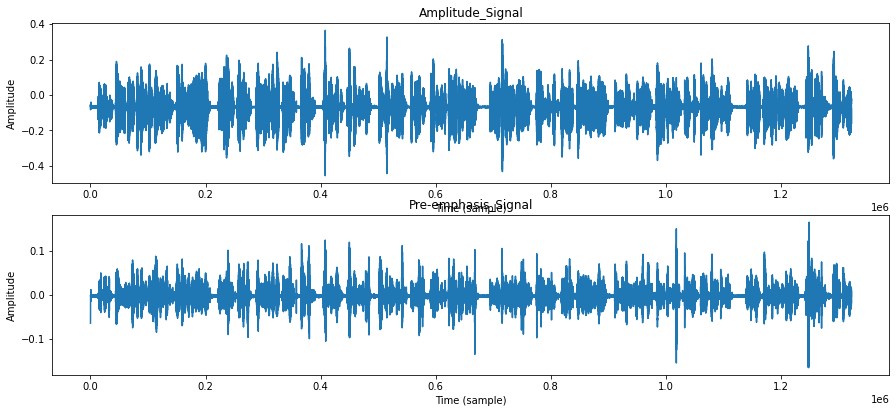

In [ ]:
file_path ='/content/drive/MyDrive/50_speakers_audio_data/Speaker0029/Speaker29_005.wav'
signal,sr = librosa.load(file_path)


Y= numpy.append(signal[0], signal[1:] - 0.95 * signal[:-1])
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(signal)
plt.title('Amplitude_Signal')
plt.xlabel('Time (sample)')
plt.ylabel('Amplitude')

# librosa.effects.preemphasis(signal, coef=0.95, zi=None, return_zf=False)

plt.subplot(3,1,2)
plt.plot(Y)
plt.title('Pre-emphasis_Signal')
plt.xlabel('Time (sample)')
plt.ylabel('Amplitude')


In [ ]:
import librosa
import os
import json

DATASET_PATH = "/content/drive/MyDrive/data"
JSON_PATH = "data.json"
# 1 sec. of audio
SAMPLES_TO_CONSIDER = 8000

In [ ]:

def preprocess_dataset(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file.
    :param dataset_path (str): Path to dataset
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :return:
    """

    # dictionary where we'll store mapping, labels, MFCCs and filenames
    data = {
        "mapping": [],
        "labels": [],
        "MFCCs": [],
        "files": []
    }

    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're at sub-folder level
        if dirpath is not dataset_path:
            
            # save label (i.e., sub-folder name) in the mapping
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))

            # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                funct(file_path)

                signal, sample_rate = librosa.load(file_path) 
                signal =  signal - 0.95*signal ;
                # print(len(signal) , SAMPLES_TO_CONSIDER)

                # drop audio files with less than pre-decided number of samples
                if len(signal) >= SAMPLES_TO_CONSIDER:
                    
                    signal = signal[:SAMPLES_TO_CONSIDER]

                    # extract MFCCs
                    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                 hop_length=hop_length)
                    MFCCsDelta = librosa.feature.delta(MFCCs)
                    MFCCsDoubleDelta = librosa.feature.delta(MFCCs , order =2)

                    MFCC_CONC =numpy.concatenate((MFCCs, MFCCsDelta, MFCCsDoubleDelta ))
                    
                    # store data for analysed track
                    data["MFCCs"].append(MFCC_CONC.T.tolist())
                    data["labels"].append(i-1)
                    data["files"].append(file_path)
                    print("{}: {}".format(file_path, i-1))

    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


if __name__ == "__main__":
    preprocess_dataset(DATASET_PATH, JSON_PATH)


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/data/05/8_05_36.wav: 50
/content/drive/MyDrive/data/05/6_05_20.wav: 50
/content/drive/MyDrive/data/05/1_05_36.wav: 50
/content/drive/MyDrive/data/05/5_05_32.wav: 50
/content/drive/MyDrive/data/05/5_05_33.wav: 50
/content/drive/MyDrive/data/05/9_05_28.wav: 50
/content/drive/MyDrive/data/05/8_05_38.wav: 50
/content/drive/MyDrive/data/05/4_05_15.wav: 50
/content/drive/MyDrive/data/05/9_05_47.wav: 50
/content/drive/MyDrive/data/05/6_05_27.wav: 50
/content/drive/MyDrive/data/05/3_05_45.wav: 50
/content/drive/MyDrive/data/05/7_05_0.wav: 50
/content/drive/MyDrive/data/05/8_05_46.wav: 50
/content/drive/MyDrive/data/05/2_05_7.wav: 50
/content/drive/MyDrive/data/05/9_05_27.wav: 50
/content/drive/MyDrive/data/05/6_05_40.wav: 50
/content/drive/MyDrive/data/05/5_05_49.wav: 50
/content/drive/MyDrive/data/05/9_05_49.wav: 50
/content/drive/MyDrive/data/05/3_05_15.wav: 50
/content/drive/MyDrive/data/05/6_05_9.wav: 50
/content/dri

In [ ]:
DATA_PATH = "data.json"
SAVED_MODEL_PATH = "model.h5"
EPOCHS = 40
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001



In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = numpy.array(data["MFCCs"])
    y = numpy.array(data["labels"])
    print("Training sets loaded!")
    return X, y

In [ ]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.
    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation
    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """

    # load dataset
    X, y = load_data(data_path)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    # print( X_train.shape, X_test.shape)
    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [ ]:
# prepare_dataset(DATA_PATH)

#Build Model


In [ ]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.
    :param input_shape (tuple): Shape of array representing a sample train. 
    :param loss (str): Loss function to use
    :param learning_rate (float):
    :return model: TensorFlow model
    """

    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(60, activation='softmax'))
  
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer="Adam",
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

In [ ]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model
    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set
    :return history: Training history
    """

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
   
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """
    plt.figure(figsize=(15,10))
    plt.rcParams['font.size'] = 18
    # fig, axs = plt.subplots(3)
    plt.subplot(2, 1, 1)

    # create accuracy subplot
    plt.plot(history.history["accuracy"], label="accuracy",color="blue")
    plt.plot(history.history['val_accuracy'], label="val_accuracy",color="black")
    plt.ylabel("Accuracy",fontname='Times New Roman')
    plt.legend(loc="lower right")
    plt.title("Accuracy evaluation",fontname='Times New Roman')

    plt.subplot(2, 1, 2)
    # create loss subplot
    plt.plot(history.history["loss"], label="loss",color="brown")
    plt.plot(history.history['val_loss'], label="val_loss",color="black")
    plt.xlabel("Epoch",fontname='Times New Roman')
    plt.ylabel("Loss",fontname='Times New Roman')
    plt.legend(loc="upper right")
    plt.title("Loss evaluation",fontname='Times New Roman')

    plt.show()

Training sets loaded!
(16, 39, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 37, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 14, 37, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 19, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 17, 32)         18464     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 17, 32)        128       
 hNormalization)                                                 
                      

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


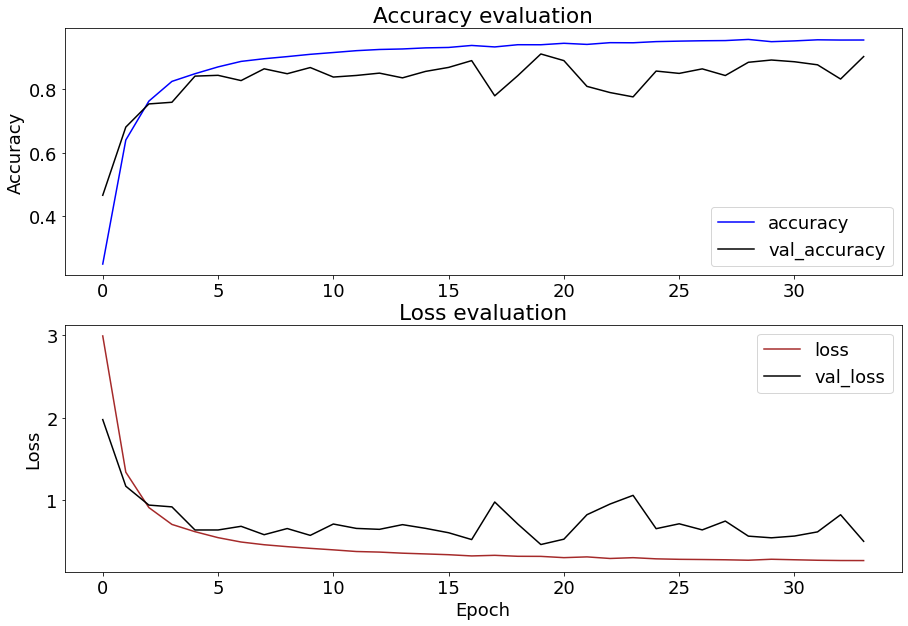

188/188 [==============================] - 3s 14ms/step - loss: 0.4719 - accuracy: 0.9047

Test loss: 0.47188204526901245, test accuracy: 90.46507477760315


In [ ]:
def main():
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    print(input_shape)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)
    # print(model.shape)
    # train network
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)

    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    # save model
    model.save(SAVED_MODEL_PATH)


if __name__ == "__main__":
    main()

In [ ]:
import librosa
import tensorflow as tf
import numpy as np

SAVED_MODEL_PATH = "model.h5"
SAMPLES_TO_CONSIDER =8000  

class _speaker_recog:
    :param model: Trained model
    """

    model = None
    _mapping = [
        "59",
        "53",
        "54",
        "57",
        "60",
        "55",
        "58",
        "51",
        "52",
        "56",
        "49",
        "42",
        "46",
        "44",
        "50",
        "48",
        "47",
        "45",
        "43",
        "41",
        "35",
        "37",
        "31",
        "34",
        "38",
        "40",
        "32",
        "39",
        "33",
        "36",
        "30",
        "22",
        "25",
        "28",
        "23",
        "29",
        "24",
        "27",
        "21",
        "26",
        "19",
        "12",
        "16",
        "13",
        "14",
        "18",
        "11",
        "17",
        "20",
        "15",
        "05",
        "09",
        "07",
        "01",
        "08",
        "06",
        "04",
        "02",
        "03",
        "10"
    ]
    _instance = None


    def predict(self, file_path):
        """
        :param file_path (str): Path to audio file to predict
        :return predicted_keyword (str): Keyword predicted by the model
        """

        # extract MFCC
        MFCCs = self.preprocess(file_path)

        # we need a 4-dim array to feed to the model for prediction: (# samples, # time steps, # coefficients, 1)
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        # get the predicted label
        predictions = self.model.predict(MFCCs)
        predicted_index = np.argmax(predictions)
        predicted_keyword = self._mapping[predicted_index]
        return predicted_keyword


    def preprocess(self, file_path, num_mfcc=13, n_fft=2048, hop_length=512):
        """Extract MFCCs from audio file.
        :param file_path (str): Path of audio file
        :param num_mfcc (int): # of coefficients to extract
        :param n_fft (int): Interval we consider to apply STFT. Measured in # of samples
        :param hop_length (int): Sliding window for STFT. Measured in # of samples
        :return MFCCs (ndarray): 2-dim array with MFCC data of shape (# time steps, # coefficients)
        """

        # load audio file
        signal, sample_rate = librosa.load(file_path)

        if len(signal) >= SAMPLES_TO_CONSIDER:
            # ensure consistency of the length of the signal
            signal = signal[:SAMPLES_TO_CONSIDER]

            # extract MFCCs
            MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                         hop_length=hop_length)
            MFCCsDelta = librosa.feature.delta(MFCCs)
            MFCCsDoubleDelta = librosa.feature.delta(MFCCs , order =2)

            MFCC_CONC =numpy.concatenate((MFCCs, MFCCsDelta, MFCCsDoubleDelta ))
        return MFCC_CONC.T


def speaker_recog():
    """Factory function for speaker_recog class.
    :return _speaker_recog._instance (_speaker_recog):
    """

    # ensure an instance is created only the first time the factory function is called
    if _speaker_recog._instance is None:
        _speaker_recog._instance = _speaker_recog()
        _speaker_recog.model = tf.keras.models.load_model(SAVED_MODEL_PATH)
    return _speaker_recog._instance




if __name__ == "__main__":

    # create instances of the speaker recognition system 
    srs = speaker_recog()
    srs1 = speaker_recog()

    # check that different instances point back to the same object (singleton)
    assert srs is srs1

    # make a prediction
    speaker = srs.predict("/content/drive/MyDrive/data/07/1_07_37.wav")
    speaker1 = srs.predict("/content/drive/MyDrive/data/04/1_04_19.wav")
    print(speaker)
    print(speaker1)